In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import distr
import common
import multiprocessing

In [4]:
import weinberg

In [5]:
PHI_RANGE     = [40.,50.]
THETA_RANGE   = [0.5,1.5]
DATA_RANGE    = [-1,1] 
THE_SIMULATOR = weinberg.simulator

In [6]:
model_details_shifts = [-2,2]
model_details_mirror = True
model_details_lnlike_nsim = 1000
model_details_map_bins = 20

In [7]:
intro_theta_nom = 1.0
intro_phi_noms  = 43,47
intro_binning   = 21

example_phi = 47.
example_theta = 1.0
example_ndata = 100

# Introducing the Model p(x|$\theta$,$\Phi$)

..................

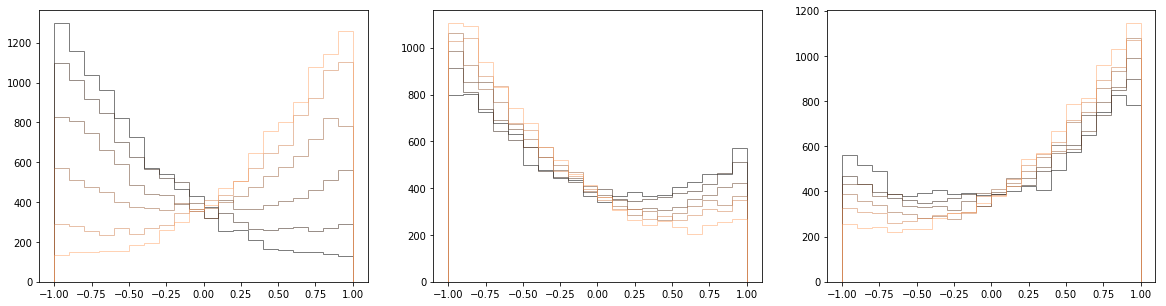

In [8]:
cm = plt.get_cmap('copper')
fig,axarr = plt.subplots(1,3)
fig.set_size_inches(20,5)
bins = np.linspace(*DATA_RANGE, num = intro_binning)

nsteps_phi, theta_nom = 6, intro_theta_nom
for i,phi in enumerate(np.linspace(*PHI_RANGE,num = nsteps_phi)):
    _=axarr[0].hist(THE_SIMULATOR(theta_nom,phi,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')

nsteps_theta, phi_nom = 6, intro_phi_noms[0]
for i,theta in enumerate(np.linspace(*THETA_RANGE,num = nsteps_theta)):
    _=axarr[1].hist(THE_SIMULATOR(theta,phi_nom,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')
    
nsteps_theta, phi_nom = 6, intro_phi_noms[1]
for i,theta in enumerate(np.linspace(*THETA_RANGE,num = nsteps_theta)):
    _=axarr[2].hist(THE_SIMULATOR(theta,phi_nom,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')

# An Example Experiment
## Taking Data

...

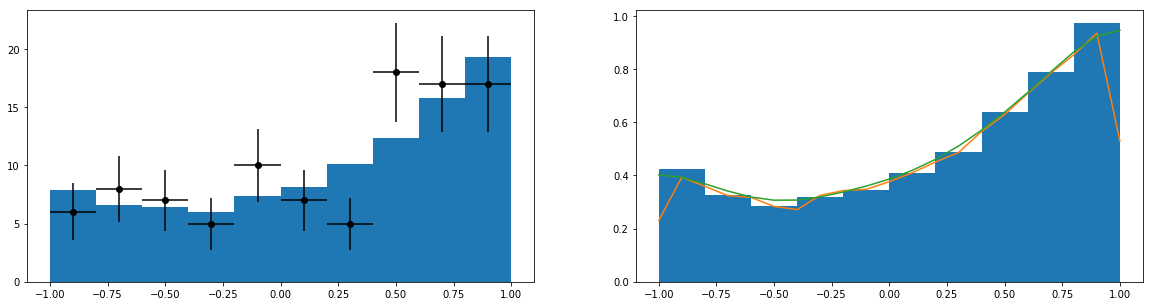

In [9]:
fig,axarr = plt.subplots(1,2)
fig.set_size_inches(20,5)


bins = np.linspace(*DATA_RANGE, num = 11)
example_data = common.collect_data(example_phi,THE_SIMULATOR, theta_nature=example_theta, n_samples = example_ndata)
datacounts,bins = np.histogram(example_data,bins = bins)
centers = bins[:-1] + (bins[1:]-bins[:-1])/2.
axarr[0].errorbar(centers,datacounts,fmt = 'o',xerr = (bins[1:]-bins[:-1])/2.,yerr = np.sqrt(datacounts), c = 'k')

n_mc = 10000
mc = THE_SIMULATOR(example_theta,example_phi,n_mc) #simulate much more than data
mccounts,_,_ = axarr[0].hist(mc,weights = [float(example_ndata)/float(n_mc)]*n_mc, bins = bins)

####

samples = THE_SIMULATOR(example_theta,example_phi,n_mc)
p = distr.Distribution(
    name = 'example_simulation',
    samples = samples,
    range = DATA_RANGE)

p.hist(bins = 10, normed = True,ax = axarr[1])

xs = np.linspace(*DATA_RANGE,num = 21)
logpdf_nomirr = p.approx_logpdf()
logpdf_mirror = p.approx_logpdf(mirror = True, mirror_shifts=model_details_shifts)

axarr[1].plot(xs,np.exp(logpdf_nomirr(xs)))
axarr[1].plot(xs,np.exp(logpdf_mirror(xs)))

## The likelihood $p(x|\theta,\Phi)$ and the prior $p(\theta|\Phi)$

......

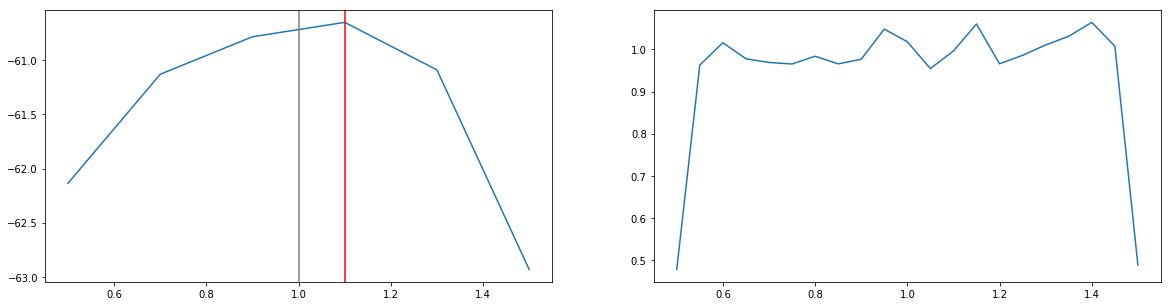

In [10]:
test_thetas = np.linspace(*THETA_RANGE,num = 6)
pool = multiprocessing.Pool(4)


nll = [pool.apply_async(common.lnlike,
                        args = (theta_test,example_data,example_phi),
                        kwds = dict(
                         simulator=THE_SIMULATOR,
                         simulation_kwargs = {'n_samples': model_details_lnlike_nsim},
                         distr_kwargs =  {'range': DATA_RANGE},
                         logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
                        )
                       ) for theta_test in test_thetas]
[r.ready() for r in nll]

pool.close()
pool.join()
nll = [r.get() for r in nll]

fig,axarr = plt.subplots(1,2)
fig.set_size_inches(20,5)

axarr[0].plot(test_thetas,nll)
axarr[0].axvline(example_theta, c = 'grey') #truth
axarr[0].axvline(test_thetas[np.argmax(nll)], c = 'r') #max NLL


example_prior = distr.Distribution('prior',range = THETA_RANGE)
xs = np.linspace(*THETA_RANGE,num = 21)
logpdf = example_prior.approx_logpdf()
axarr[1].plot(xs,np.exp(logpdf(xs)))

## The posterior $p(\theta|x,\Phi)$

In [11]:
example_posterior = common.calculate_posterior(
    example_prior,example_data,example_phi,
    lnprob_args = dict(simulator = THE_SIMULATOR,
                       simulation_kwargs = {'n_samples': model_details_lnlike_nsim},
                       distr_kwargs =  {'range': DATA_RANGE},
                       logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
                  ),
    n_chainlen = 50
)

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

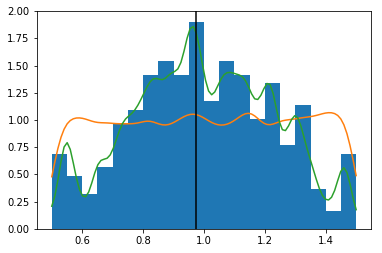

In [12]:
xs = np.linspace(*THETA_RANGE,num = model_details_map_bins+1)
example_posterior.hist(bins = model_details_map_bins,normed = True)
example_prior.plot()
example_posterior.plot()
example_best_theta = example_posterior.map(bins = model_details_map_bins)
plt.axvline(example_best_theta, c = 'k')

In [ ]:
emcee_kwargs = dict(
    n_chainlen = 30,
    lnprob_args = dict(simulator = THE_SIMULATOR,
                       simulation_kwargs = {'n_samples': model_details_lnlike_nsim},
                       distr_kwargs =  {'range': DATA_RANGE},
                       logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
                       )
)
eig_kwargs = dict(emcee_kwargs = emcee_kwargs, sim_n_data = example_ndata, map_bins = model_details_map_bins)

# for x in eig_test_phis.reshape(-1,1):
#     eig.append(common.expected_information_gain(x,example_posterior, emcee_kwargs = emcee_kwargs,))


res_sg = common.design_next_experiment_simplegrid(example_posterior,PHI_RANGE,eig_kwargs)

EIG [ 40.]
simulating with  0.975 40.0
simulating with  0.975 40.0
simulating with  0.975 40.0
simulating with  0.975 40.0
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

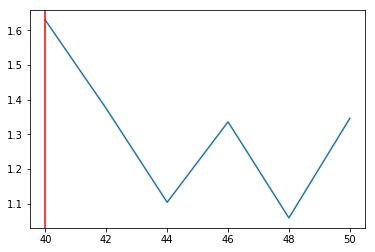

In [15]:
example_next_phi = res_sg[0]
plt.plot(res_sg[1],res_sg[2])
plt.axvline(example_next_phi, c = 'r')

## The expected improvement in $\theta$

In [16]:
new_data_expected = common.collect_data(example_next_phi,THE_SIMULATOR,theta_nature=example_best_theta, n_samples = example_ndata)
example_exp_posterior = common.calculate_posterior(
    example_posterior,new_data_expected,example_next_phi,
    lnprob_args = dict(simulator = THE_SIMULATOR,
                       simulation_kwargs = {'n_samples': model_details_lnlike_nsim},
                       distr_kwargs =  {'range': DATA_RANGE},
                       logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
                  ),
    n_chainlen = 50
)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

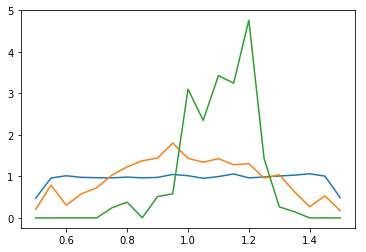

In [17]:
xs = np.linspace(*THETA_RANGE,num = 21)
logpdf_prior = example_prior.approx_logpdf()
logpdf_postr = example_posterior.approx_logpdf()
logpdf_exp_postr = example_exp_posterior.approx_logpdf()
plt.plot(xs,np.exp(logpdf_prior(xs)))
plt.plot(xs,np.exp(logpdf_postr(xs)))
plt.plot(xs,np.exp(logpdf_exp_postr(xs)))

## The whole story for a single 'science iteration'

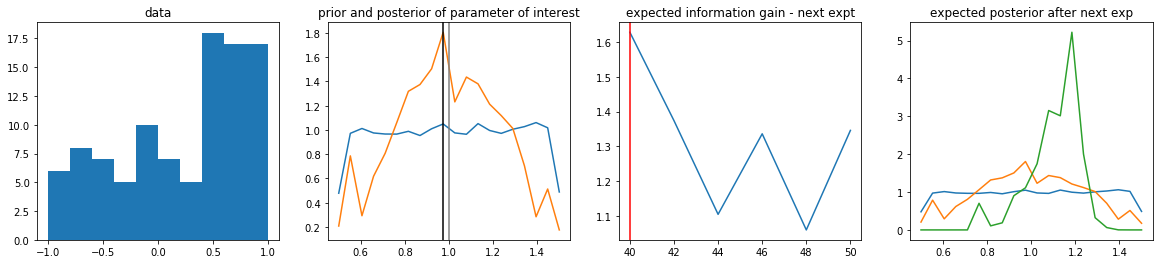

In [21]:
def summary_plot(data,prior,posterior,best_theta,true_theta,res_sg,expected_posterior):
    fig,axarr = plt.subplots(1,4)
    fig.set_size_inches(20,4)
    bins = np.linspace(*DATA_RANGE, num = 11)
    axarr[0].hist(data, bins = bins)
    axarr[0].set_title('data')


    xs = np.linspace(*THETA_RANGE,num = model_details_map_bins)
    logpdf_prior = prior.approx_logpdf()
    logpdf_postr = posterior.approx_logpdf()
    axarr[1].plot(xs,np.exp(logpdf_prior(xs)))
    axarr[1].plot(xs,np.exp(logpdf_postr(xs)))
    axarr[1].axvline(best_theta, c = 'k')
    axarr[1].axvline(true_theta, c = 'grey')
    axarr[1].set_title('prior and posterior of parameter of interest')

    axarr[2].plot(res_sg[1],res_sg[2])
    axarr[2].axvline(res_sg[0], c = 'r')
    axarr[2].set_title('expected information gain - next expt')

    logpdf_prior = prior.approx_logpdf()
    logpdf_postr = posterior.approx_logpdf()
    logpdf_exp_postr = expected_posterior.approx_logpdf()
    axarr[3].plot(xs,np.exp(logpdf_prior(xs)))
    axarr[3].plot(xs,np.exp(logpdf_postr(xs)))
    axarr[3].plot(xs,np.exp(logpdf_exp_postr(xs)))
    axarr[3].set_title('expected posterior after next exp')
    
summary_plot(example_data,example_prior,example_posterior,example_best_theta,example_theta,res_sg,example_exp_posterior)